In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [3]:
box = pd.read_csv('data/train_solution_bounding_boxes (1).csv')
box

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


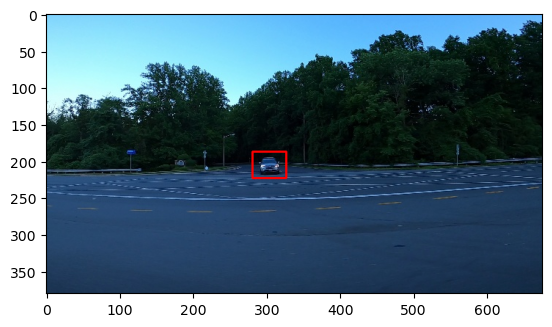

In [4]:
sample = cv2.imread('data/training_images/vid_4_1000.jpg')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
point = box.iloc[0]
pt1 = (int(point['xmin']), int(point['ymax']))
pt2 = (int(point['xmax']), int(point['ymin']))
cv2.rectangle(sample, pt1, pt2, color=(255,0,0), thickness=2)
plt.imshow(sample)


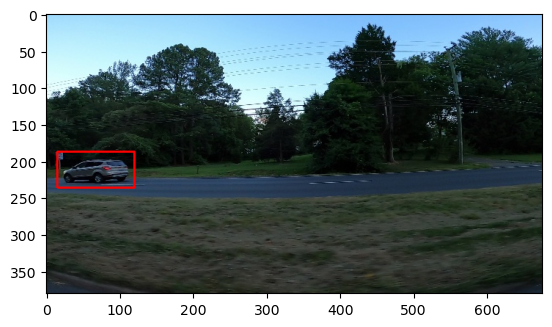

In [5]:
sample = cv2.imread('data/training_images/vid_4_10000.jpg')
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)
point = box.iloc[1]
pt1 = (int(point['xmin']), int(point['ymax']))
pt2 = (int(point['xmax']), int(point['ymin']))
cv2.rectangle(sample, pt1, pt2, color=(255,0,0), thickness=2)
plt.imshow(sample)

YOLO 구현

In [ ]:
#YOLO 로드
net = cv2.dnn.readNetFromDarknet("/Users/sunghyunkim/darknet/cfg/yolov3.cfg", "/Users/sunghyunkim/darknet/yolov3.weights")
classes = []
with open("/Users/sunghyunkim/darknet/coco.names", "r") as f:
    classes = [line.strip() for line in f.readlines()]
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [24]:
# 이미지 가져오기
img = cv2.imread("data/training_images/vid_4_10000.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
height, width, channels = img.shape

In [25]:
#이미지를 blob으로 변환 (네트워크에서는 이미지를 바로 사용할 수 없기에..)
blob = cv2.dnn.blobFromImage(img, 1/256, (416, 416), (0, 0, 0), swapRB=True, crop=False)
net.setInput(blob)

In [26]:
#outs는 출력으로 탐지된 개체에 대한 모든 정보와 위치를 제공
outs = net.forward(output_layers)

In [28]:
#정보를 화면에 표시
class_ids = []
confidences = []
boxes = []
for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            #object detected
            center_x = int(detection[0]*width)
            center_y = int(detection[1]*height)
            w = int(detection[2]*width)
            h = int(detection[3]*height)
            #좌표
            x = int(center_x - w/2)
            y = int(center_y - h/2)
            boxes.append([x,y,w,h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

In [29]:
#non maximum suppersion : 동일한 객체에 생기는 바운딩 박스 제거
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

22 197 92 32


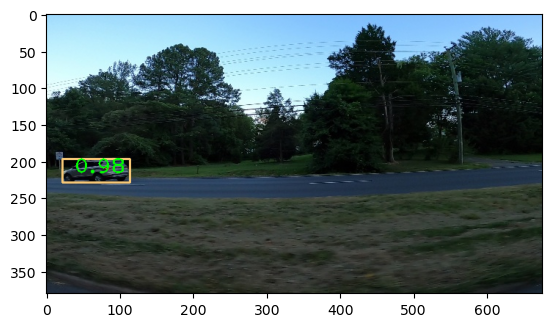

In [ ]:
#모든 정보를 화면에 출력
# box : 감지된 개체를 둘러싼 사각형의 좌표 (x, y, w, h)
# label : 감지된 물체의 이름 
# confidence : 0~1 사이의 탐지에 대한 신뢰도 
font = cv2.FONT_HERSHEY_PLAIN
colors = np.random.uniform(0, 255, size=(len(boxes), 3))

for i in indexes.flatten():
    x, y, w, h = boxes[i]
    print(x, y, w, h)
    label = str(classes[class_ids[i]])
    confidence = str(round(confidences[i],2))
    color = colors[i]
    cv2.rectangle(img, (x,y),((x+w), (y+h)), color, 2)
    cv2.putText(img, label + " "+confidence, (x, y+20), font, 2, (0, 255, 0), 2)

plt.imshow(img)

In [40]:
def predict_yolo(img_path):
    #이미지 가져오기
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, channels = img.shape

    blob = cv2.dnn.blobFromImage(img, 1/256, (416, 416), (0, 0, 0,), swapRB=True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                #object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                #좌표
                x = int(center_x - w/2)
                y = int(center_y - h/2)
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

    font = cv2.FONT_HERSHEY_PLAIN
    colors = np.random.uniform(0, 255, size=(len(boxes), 3))
    if len(indexes)>0:
        for i in indexes.flatten():
            x, y, w, h = boxes[i]
            print(x,y,w,h)
            label = str(classes[class_ids[i]])
            confidence = str(round(confidences[i], 2))
            color = colors[i]
            cv2.rectangle(img, (x,y), ((x+w), (y+h)), color, 2)
            cv2.putText(img, label + " " + confidence, (x, y+20), font, 2, (0, 255, 0), 2)

        plt.imshow(img)
    else:
        print('탐지된 물체가 없습니다.')

325 96 8 17
353 79 10 23
400 41 16 39
522 182 61 28
527 130 8 13
510 131 7 13


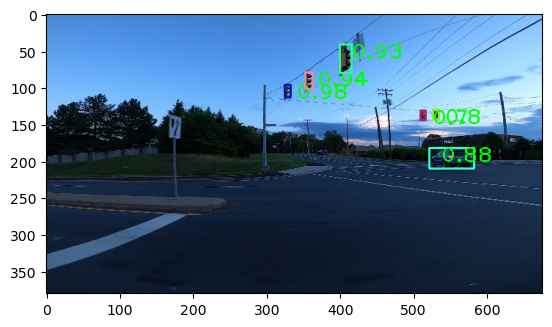

In [48]:
import glob
import random

paths = glob.glob("data/training_images/*.jpg")

img_path = random.choice(paths)

predict_yolo(img_path)

429 180 103 27
239 185 75 25


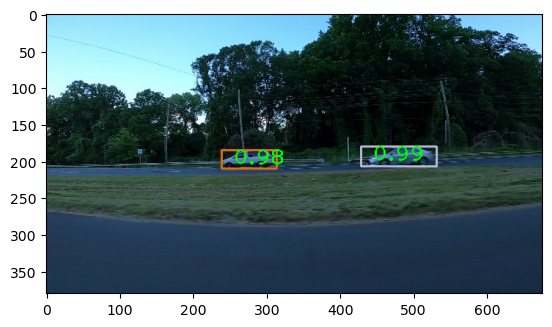

In [59]:
img_path = random.choice(paths)
predict_yolo(img_path)